# Velocity and acceleration diagnostics : Global hist

- [ ] global histogram


In [2]:
import os
from glob import glob

import numpy as np
import pandas as pd
import xarray as xr
import dask.dataframe as dd
import dask.array as da

# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
# import geopandas as gpd
from shapely.geometry import Polygon

%matplotlib inline
from matplotlib import pyplot as plt


import drifters.utils as ut
import pynsitu as pin

from dask.delayed import delayed

import GDP_lib as gdp

from GDP_lib import root_dir

In [3]:
from dask.distributed import Client

if True:
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client

    # cluster = PBSCluster()
    # w = cluster.scale(jobs=3) # 2 not enough for lon, lat, year, binning
    cluster = PBSCluster(cores=3, processes=3, walltime="04:00:00")
    w = cluster.scale(jobs=8)
else:
    from dask.distributed import LocalCluster

    cluster = LocalCluster()

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.84:8787/status,
Dashboard: http://10.148.0.84:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.84:54831,Workers: 0
Dashboard: http://10.148.0.84:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
parquet_argos = os.path.join(root_dir, "argos_av_time.parquet")
parquet_gps = os.path.join(root_dir, "gps_av_time.parquet")

In [5]:
df_gps = dd.read_parquet(parquet_gps).persist()
df_argos = dd.read_parquet(parquet_argos).persist()

In [6]:
df_gps

,id,lon,lat,vex,vny,vxy,ve,vn,ae,an,aen,aex,any,axy,typebuoy,gap,deploy_date,deploy_lat,deploy_lon,end_date,end_lat,end_lon,drogue_lost_date,typedeath,lon360,err_lat,err_lon,err_ve,err_vn
npartitions=148,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,float32,float32,float64,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,object,float64,datetime64[ns],float64,float64,datetime64[ns],float64,float64,datetime64[ns],float64,float32,float32,float32,float32,float32
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


___________________________
# Global histogram

In [78]:
def print_mean_var(df):
    for l in df.columns:
        print(
            l
            + f": mean = {df[l].mean().compute()}, variance = {df[l].var().compute()}, std = {df[l].std().compute()}"
        )

In [79]:
print_mean_var(df_gps[["ve", "vn", "ae", "an", "vex", "vny", "aex", "any"]])

ve: mean = 0.011794044249571098, variance = 0.0628432184457779, std = 0.2506854832172394
vn: mean = 0.0033113528339724953, variance = 0.04800022020936012, std = 0.21908952295780182
ae: mean = -2.767218635963441e-10, variance = 1.4280341147867293e-10, std = 1.1950038137122113e-05
an: mean = -7.194039849104883e-10, variance = 1.4384357997304564e-10, std = 1.1993480728005763e-05
vex: mean = 0.011957733667706385, variance = 0.06443895856264234, std = 0.25384829832528394
vny: mean = -0.0010015627356488742, variance = 0.12362395520161872, std = 0.35160198406951393
aex: mean = -8.944412796126405e-10, variance = 6.241906007793556e-10, std = 2.4983806771173916e-05
any: mean = -2.009514858902962e-09, variance = 5.235646728768863e-10, std = 2.288153563196505e-05


In [80]:
print_mean_var(df_argos[["ve", "vn", "ae", "an", "vex", "vny", "aex", "any"]])

ve: mean = 0.005583182291101385, variance = 0.07471064478158951, std = 0.27333247661590576
vn: mean = 0.005280918545608172, variance = 0.0525890477001667, std = 0.22932301461696625
ae: mean = -5.596267706297923e-10, variance = 3.04483495199027e-10, std = 1.7449455441331887e-05
an: mean = 2.750317536421524e-11, variance = 2.323882180063487e-10, std = 1.5244284765325945e-05
vex: mean = 0.005567501588995124, variance = 0.07575240500319723, std = 0.2752315479795098
vny: mean = 0.005090686674079184, variance = 0.1401732260550757, std = 0.3743971501695435
aex: mean = -2.493054724798962e-09, variance = 2.4987916769100803e-09, std = 4.998791530870317e-05
any: mean = -4.6236329216281857e-10, variance = 1.5814457297611844e-09, std = 3.97673953102436e-05


In [26]:
?da.histogram

Signature:
da.histogram(
    a,
    bins=None,
    range=None,
    normed=False,
    weights=None,
    density=None,
)
Docstring:
Blocked variant of :func:`numpy.histogram`.

Parameters
----------
a : dask.array.Array
    Input data; the histogram is computed over the flattened
    array. If the ``weights`` argument is used, the chunks of
    ``a`` are accessed to check chunking compatibility between
    ``a`` and ``weights``. If ``weights`` is ``None``, a
    :py:class:`dask.dataframe.Series` object can be passed as
    input data.
bins : int or sequence of scalars, optional
    Either an iterable specifying the ``bins`` or the number of ``bins``
    and a ``range`` argument is required as computing ``min`` and ``max``
    over blocked arrays is an expensive operation that must be performed
    explicitly.
    If `bins` is an int, it defines the number of equal-width
    bins in the given range (10, by default). If `bins` is a
    sequence, it defines a monotonically increasing array 

In [54]:
def plot_histogram(darray, ax, bins=np.linspace(-2, 2, 100), **kwargs):
    h, b = da.histogram(darray, bins=bins, density=True)
    ax.plot(bins[:-1] + np.diff(bins) / 2, h, **kwargs)

Text(0.5, 0, 'acceleration [$m/s^2$]')

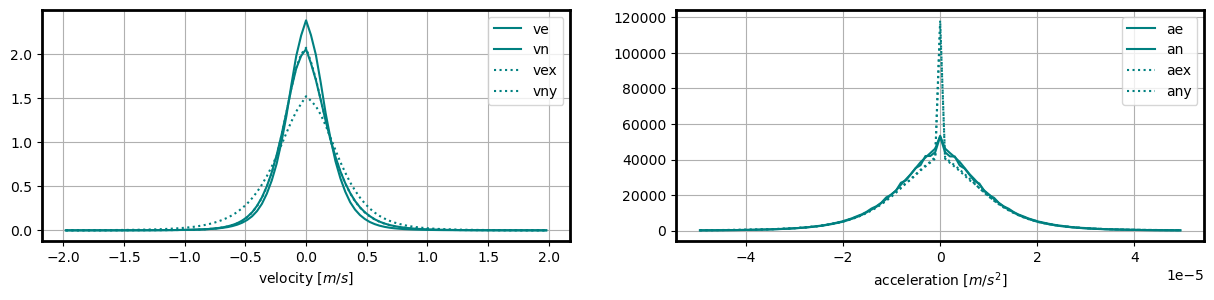

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(15, 3))
axs = axs.flatten()
plot_histogram(df_gps["ve"], axs[0], color="teal", label="ve")
plot_histogram(df_gps["vn"], axs[0], color="teal", label="vn")
plot_histogram(df_gps["vex"], axs[0], color="teal", label="vex", ls=":")
plot_histogram(df_gps["vny"], axs[0], color="teal", label="vny", ls=":")
plot_histogram(
    df_gps["ae"],
    axs[1],
    bins=np.linspace(-5 * 1e-5, 5 * 1e-5, 100),
    color="teal",
    label="ae",
)
plot_histogram(
    df_gps["an"],
    axs[1],
    bins=np.linspace(-5 * 1e-5, 5 * 1e-5, 100),
    color="teal",
    label="an",
)
plot_histogram(
    df_gps["aex"],
    axs[1],
    bins=np.linspace(-5 * 1e-5, 5 * 1e-5, 100),
    color="teal",
    label="aex",
    ls=":",
)
plot_histogram(
    df_gps["any"],
    axs[1],
    bins=np.linspace(-5 * 1e-5, 5 * 1e-5, 100),
    color="teal",
    label="any",
    ls=":",
)
for ax in axs:
    ax.grid()
    ax.legend()
axs[0].set_xlabel(r"velocity [$m/s$]")
axs[1].set_xlabel(r"acceleration [$m/s^2$]")

Text(0.5, 0, 'acceleration [$m/s^2$]')

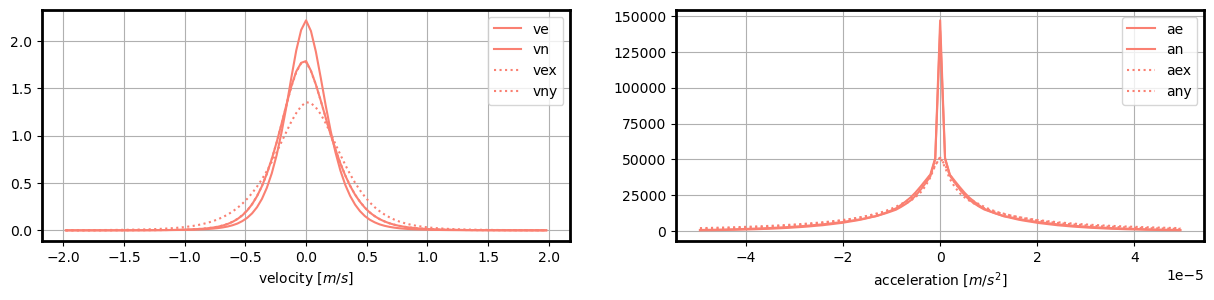

In [72]:
fig, axs = plt.subplots(1, 2, figsize=(15, 3))
axs = axs.flatten()
plot_histogram(df_argos["ve"], axs[0], color="salmon", label="ve")
plot_histogram(df_argos["vn"], axs[0], color="salmon", label="vn")
plot_histogram(df_argos["vex"], axs[0], color="salmon", label="vex", ls=":")
plot_histogram(df_argos["vny"], axs[0], color="salmon", label="vny", ls=":")
plot_histogram(
    df_argos["ae"],
    axs[1],
    bins=np.linspace(-5 * 1e-5, 5 * 1e-5, 100),
    color="salmon",
    label="ae",
)
plot_histogram(
    df_argos["an"],
    axs[1],
    bins=np.linspace(-5 * 1e-5, 5 * 1e-5, 100),
    color="salmon",
    label="an",
)
plot_histogram(
    df_argos["aex"],
    axs[1],
    bins=np.linspace(-5 * 1e-5, 5 * 1e-5, 100),
    color="salmon",
    label="aex",
    ls=":",
)
plot_histogram(
    df_argos["any"],
    axs[1],
    bins=np.linspace(-5 * 1e-5, 5 * 1e-5, 100),
    color="salmon",
    label="any",
    ls=":",
)
for ax in axs:
    ax.grid()
    ax.legend()
axs[0].set_xlabel(r"velocity [$m/s$]")
axs[1].set_xlabel(r"acceleration [$m/s^2$]")

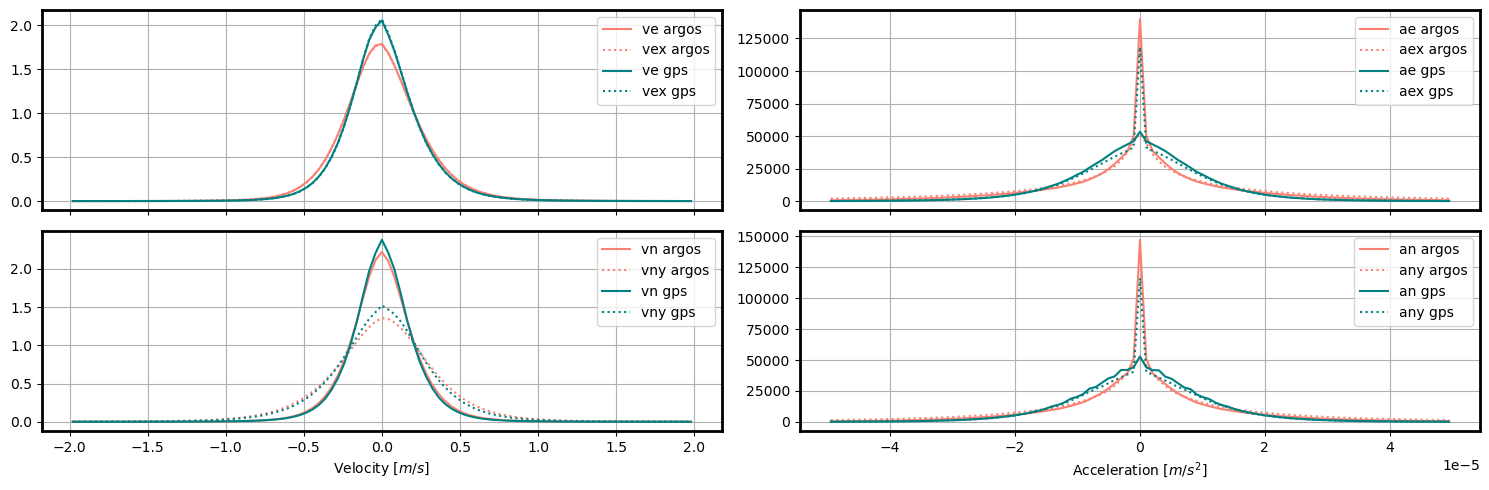

In [66]:
fig, axs = plt.subplots(2, 2, sharex="col", figsize=(15, 5))
axs = axs.flatten()
plot_histogram(df_argos["ve"], axs[0], color="salmon", label="ve argos")
plot_histogram(df_argos["vn"], axs[2], color="salmon", label="vn argos")
plot_histogram(df_argos["vex"], axs[0], color="salmon", label="vex argos", ls=":")
plot_histogram(df_argos["vny"], axs[2], color="salmon", label="vny argos", ls=":")
plot_histogram(df_gps["ve"], axs[0], color="teal", label="ve gps")
plot_histogram(df_gps["vn"], axs[2], color="teal", label="vn gps")
plot_histogram(df_gps["vex"], axs[0], color="teal", label="vex gps", ls=":")
plot_histogram(df_gps["vny"], axs[2], color="teal", label="vny gps", ls=":")
plot_histogram(
    df_argos["ae"],
    axs[1],
    bins=np.linspace(-5 * 1e-5, 5 * 1e-5, 100),
    color="salmon",
    label="ae argos",
)
plot_histogram(
    df_argos["an"],
    axs[3],
    bins=np.linspace(-5 * 1e-5, 5 * 1e-5, 100),
    color="salmon",
    label="an argos",
)
plot_histogram(
    df_argos["aex"],
    axs[1],
    bins=np.linspace(-5 * 1e-5, 5 * 1e-5, 100),
    color="salmon",
    label="aex argos",
    ls=":",
)
plot_histogram(
    df_argos["any"],
    axs[3],
    bins=np.linspace(-5 * 1e-5, 5 * 1e-5, 100),
    color="salmon",
    label="any argos",
    ls=":",
)
plot_histogram(
    df_gps["ae"],
    axs[1],
    bins=np.linspace(-5 * 1e-5, 5 * 1e-5, 100),
    color="teal",
    label="ae gps",
)
plot_histogram(
    df_gps["an"],
    axs[3],
    bins=np.linspace(-5 * 1e-5, 5 * 1e-5, 100),
    color="teal",
    label="an gps",
)
plot_histogram(
    df_gps["aex"],
    axs[1],
    bins=np.linspace(-5 * 1e-5, 5 * 1e-5, 100),
    color="teal",
    label="aex gps",
    ls=":",
)
plot_histogram(
    df_gps["any"],
    axs[3],
    bins=np.linspace(-5 * 1e-5, 5 * 1e-5, 100),
    color="teal",
    label="any gps",
    ls=":",
)
for ax in axs:
    ax.grid()
    ax.legend()
axs[2].set_xlabel(r"Velocity [$m/s$]")
axs[3].set_xlabel(r"Acceleration [$m/s^2$]")
fig.tight_layout(rect=[0, 0, 1, 1])  # left, bottom, right, top (default is 0,0,1,1)

In [112]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
